## <font size=5> <strong>Analysis about ED
 

## I. Importing essential libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import os
import warnings
import sys

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Dropout, Embedding
from keras.losses import CategoricalCrossentropy
from keras.optimizers import SGD, Adam
warnings.filterwarnings('ignore')

# show progress
def show_progress(total,current):
    percent = current*100/total
    progress = '▉' * int(percent/10)
    sys.stdout.write(f"\rProgress:[{progress:<10}] {percent:.1f}%")
    sys.stdout.flush()

## II. Importing and understanding our dataset 

In [82]:
dataset_ed = pd.read_csv('ED.csv')
dataset_b12 = pd.read_csv('B12.csv')
dataset_d = pd.read_csv('D.csv')
dateset_bmx = pd.read_csv('BMI.csv')
dataset_demo = pd.read_csv('DEMO_B.csv')
dataset_fda = pd.read_csv('FDA.csv')
dataset_sst = pd.read_csv('SST.csv')
dataset_diq = pd.read_csv('DIQ.csv')
dataset_ald = pd.read_csv('ALD.csv')
dataset_smoke = pd.read_csv('SMOKE.csv')
dataset_sports = pd.read_csv('SPORTS.csv')

#### Create interviewee info data

In [83]:
# create interviewee info data
info_dataset = pd.merge(dataset_demo, dateset_bmx, on='SEQN', how='left')
info_dataset = pd.merge(info_dataset, dataset_fda, on='SEQN', how='left')
info_dataset = pd.merge(info_dataset, dataset_sst, on='SEQN', how='left')
info_dataset = pd.merge(info_dataset, dataset_diq, on='SEQN', how='left')
info_dataset = pd.merge(info_dataset, dataset_ald, on='SEQN', how='left')
info_dataset = pd.merge(info_dataset, dataset_smoke, on='SEQN', how='left')
info_dataset = pd.merge(info_dataset, dataset_sports, on='SEQN', how='left')

info_dataset = info_dataset.loc[:, ['BMXWT', 'SEQN', 'BMXBMI', 'RIAGENDR', 'RIDAGEYR',
                                    'RIDRETH1', 'DIQ010', 'SSTESTO', 'FDACODE1', 'FDACODE2',
                                    'FDACODE3', 'FDACODE4', 'FDACODE5', 'FDACODE6', 'PAD320',
                                    'PAD480', 'SMQ020', 'ALD100']]

info_dataset.head(5)

,BMXWT,SEQN,BMXBMI,RIAGENDR,RIDAGEYR,RIDRETH1,DIQ010,SSTESTO,FDACODE1,FDACODE2,FDACODE3,FDACODE4,FDACODE5,FDACODE6,PAD320,PAD480,BMXBMI,SMQ020,ALD100
0,91.7,9966.0,30.22,1.0,39.0,3.0,2.0,4.38,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,30.22,1.0,1.0
1,84.0,9967.0,29.98,1.0,23.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,29.98,2.0,1.0
2,51.7,9968.0,24.62,2.0,84.0,3.0,2.0,NaN,1720.0,1721.0,NaN,NaN,NaN,NaN,2.0,2.0,24.62,1.0,1.0
3,51.7,9968.0,24.62,2.0,84.0,3.0,2.0,NaN,506.0,507.0,514.0,NaN,NaN,NaN,2.0,2.0,24.62,1.0,1.0
4,51.7,9968.0,24.62,2.0,84.0,3.0,2.0,NaN,1034.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,24.62,1.0,1.0


In [84]:
# preprocess info dataset
drop_index = info_dataset[info_dataset['RIAGENDR'] == 2].index
print(drop_index, 'deleted')
info_dataset.drop(drop_index, inplace=True)
info_dataset = info_dataset.drop(columns=['RIAGENDR'])

for idx in ['FDACODE1', 'FDACODE2','FDACODE3', 'FDACODE4', 'FDACODE5', 'FDACODE6']:
    drop_index = info_dataset[((info_dataset[idx] > 500) & (info_dataset[idx] < 700))
                              | (info_dataset[idx] == 912)].index
    print(drop_index, 'deleted')
    info_dataset.drop(drop_index, inplace=True)
    info_dataset = info_dataset.drop(columns=[idx])

drop_index = info_dataset[info_dataset['SSTESTO'] < 3].index
print(drop_index, 'deleted')
info_dataset.drop(drop_index, inplace=True)
info_dataset = info_dataset.drop(columns=['SSTESTO'])

drop_index = info_dataset[info_dataset['DIQ010'].isin([1,7,9])].index
print(drop_index, 'deleted')
info_dataset.drop(drop_index, inplace=True)
info_dataset = info_dataset.drop(columns=['DIQ010'])

drop_index = info_dataset[info_dataset['PAD320'].isin([7,9])].index
print(drop_index, 'deleted')
info_dataset.drop(drop_index, inplace=True)
info_dataset = info_dataset.drop(columns=['PAD320'])

drop_index = info_dataset[info_dataset['PAD480'].isin([77,99])].index
print(drop_index, 'deleted')
info_dataset.drop(drop_index, inplace=True)
info_dataset = info_dataset.drop(columns=['PAD480'])

drop_index = info_dataset[info_dataset['SMQ020'].isin([7,9])].index
print(drop_index, 'deleted')
info_dataset.drop(drop_index, inplace=True)
info_dataset = info_dataset.drop(columns=['SMQ020'])

drop_index = info_dataset[info_dataset['ALD100'].isin([7,9])].index
print(drop_index, 'deleted')
info_dataset.drop(drop_index, inplace=True)
info_dataset = info_dataset.drop(columns=['ALD100'])


Int64Index([    2,     3,     4,     5,     7,     9,    10,    11,    12,
               13,
            ...
            18398, 18399, 18400, 18401, 18402, 18403, 18404, 18405, 18409,
            18413],
           dtype='int64', length=9867) deleted
Int64Index([   15,    24,    25,    31,    54,    57,    61,    63,    95,
               97,
            ...
            18319, 18325, 18342, 18348, 18349, 18352, 18406, 18408, 18411,
            18416],
           dtype='int64', length=2142) deleted
Int64Index([  917,  1550,  2044,  4210,  4371,  5397,  5630,  5653,  6278,
             6409,  7186,  8489,  9038,  9229, 10165, 10859, 11149, 11168,
            11437, 11597, 12715, 13424, 13692, 13705, 14096, 14276, 14388,
            14392, 16674, 17984, 18044],
           dtype='int64') deleted
Int64Index([5152], dtype='int64') deleted
Int64Index([], dtype='int64') deleted
Int64Index([7112, 7935, 8776, 9285, 10932, 11234, 14785, 16574, 17013], dtype='int64') deleted
Int64Index([], dtype=

#### Merge datasets and remove SQEN col, reset index, drop unused cols

In [85]:
merged_dataset = pd.merge(dataset_ed, dataset_b12, on='SEQN', how='left')
merged_dataset = merged_dataset.loc[:, ['KIQ400', 'LBDFOLSI', 'LBDB12SI', 'SEQN']]
merged_dataset = pd.merge(info_dataset, merged_dataset, on='SEQN', how='left')
merged_dataset = pd.merge(merged_dataset, dataset_d, on='SEQN', how='left')
merged_dataset = merged_dataset.drop(columns=['SEQN'])

In [86]:
print(merged_dataset)

      BMXWT  BMXBMI  RIDAGEYR  RIDRETH1  BMXBMI  KIQ400  LBDFOLSI  LBDB12SI  \
0      91.7   30.22      39.0       3.0   30.22     1.0      22.4    305.53   
1      84.0   29.98      23.0       4.0   29.98     1.0      39.4    687.82   
2     139.1   39.23      16.0       2.0   39.23     NaN       NaN       NaN   
3     101.5   33.84      44.0       3.0   33.84     1.0      43.3    341.69   
4      74.5   25.18      13.0       4.0   25.18     NaN       NaN       NaN   
...     ...     ...       ...       ...     ...     ...       ...       ...   
5602    NaN     NaN      77.0       3.0     NaN     2.0      42.6    481.18   
5603   57.3   28.66      11.0       4.0   28.66     NaN       NaN       NaN   
5604   10.0     NaN       0.0       3.0     NaN     NaN       NaN       NaN   
5605   37.7   20.84      10.0       5.0   20.84     NaN       NaN       NaN   
5606   72.9   25.05      31.0       2.0   25.05     1.0      23.6    312.91   

      LBDVIDMS  
0         70.6  
1         51.6  


#### Delete rows including na

In [87]:
merged_dataset = merged_dataset.dropna()
print(merged_dataset)

      BMXWT  BMXBMI  RIDAGEYR  RIDRETH1  BMXBMI  KIQ400  LBDFOLSI  LBDB12SI  \
0      91.7   30.22      39.0       3.0   30.22     1.0      22.4    305.53   
1      84.0   29.98      23.0       4.0   29.98     1.0      39.4    687.82   
3     101.5   33.84      44.0       3.0   33.84     1.0      43.3    341.69   
6      72.3   22.51      36.0       3.0   22.51     1.0      42.4    460.51   
11     57.3   22.33      60.0       5.0   22.33     2.0      52.5    474.53   
...     ...     ...       ...       ...     ...     ...       ...       ...   
5596   80.5   24.87      43.0       4.0   24.87     1.0      27.4    295.20   
5597   85.8   25.43      44.0       3.0   25.43     1.0      29.2    442.06   
5598   84.7   27.44      40.0       4.0   27.44     1.0      19.0    370.48   
5601   64.5   25.94      32.0       1.0   25.94     2.0      16.1    366.79   
5606   72.9   25.05      31.0       2.0   25.05     1.0      23.6    312.91   

      LBDVIDMS  
0         70.6  
1         51.6  


#### Delete incorrect data

In [89]:
drop_index = merged_dataset[merged_dataset['KIQ400'].isin([7, 9])].index
print(drop_index, 'deleted.')
merged_dataset.drop(drop_index, inplace=True)

drop_index = merged_dataset[merged_dataset['LBDB12SI'] > 5000].index
print(drop_index, 'deleted')
merged_dataset.drop(drop_index, inplace=True)

drop_index = merged_dataset[merged_dataset['LBDFOLSI'] > 500].index
print(drop_index, 'deleted')
merged_dataset.drop(drop_index, inplace=True)

merged_dataset = merged_dataset.reset_index(drop=True)

print(merged_dataset)

Int64Index([], dtype='int64') deleted.
Int64Index([], dtype='int64') deleted
Int64Index([], dtype='int64') deleted
      BMXWT  BMXBMI  RIDAGEYR  RIDRETH1  BMXBMI  KIQ400  LBDFOLSI  LBDB12SI  \
0      91.7   30.22      39.0       3.0   30.22     1.0      22.4    305.53   
1      84.0   29.98      23.0       4.0   29.98     1.0      39.4    687.82   
2     101.5   33.84      44.0       3.0   33.84     1.0      43.3    341.69   
3      72.3   22.51      36.0       3.0   22.51     1.0      42.4    460.51   
4      57.3   22.33      60.0       5.0   22.33     2.0      52.5    474.53   
...     ...     ...       ...       ...     ...     ...       ...       ...   
1965   80.5   24.87      43.0       4.0   24.87     1.0      27.4    295.20   
1966   85.8   25.43      44.0       3.0   25.43     1.0      29.2    442.06   
1967   84.7   27.44      40.0       4.0   27.44     1.0      19.0    370.48   
1968   64.5   25.94      32.0       1.0   25.94     2.0      16.1    366.79   
1969   72.9   25

#### Analysing the target KIQ400

In [90]:
KIQ400 = merged_dataset['KIQ400']

#### Check correlation between columns

In [91]:
print(merged_dataset.describe())

             BMXWT       BMXBMI     RIDAGEYR     RIDRETH1       BMXBMI  \
count  1970.000000  1970.000000  1970.000000  1970.000000  1970.000000   
mean     85.511117    27.796964    48.803046     2.785279    27.796964   
std      19.300721     5.655188    18.034975     1.014414     5.655188   
min      45.300000    16.160000    20.000000     1.000000    16.160000   
25%      72.700000    24.315000    34.000000     3.000000    24.315000   
50%      82.800000    27.140000    47.000000     3.000000    27.140000   
75%      94.200000    29.980000    63.000000     3.000000    29.980000   
max     171.300000    64.160000    85.000000     5.000000    64.160000   

            KIQ400     LBDFOLSI     LBDB12SI     LBDVIDMS  
count  1970.000000  1970.000000  1970.000000  1970.000000  
mean      1.768528    32.085685   368.191792    59.066345  
std       0.991700    32.928056   182.103762    19.439703  
min       1.000000     2.500000    46.490000    13.600000  
25%       1.000000    19.900000  

## Exploratory Data Analysis (EDA)

### First, analysing the target variable:

KIQ400      1.000000
RIDAGEYR    0.572130
LBDFOLSI    0.147510
LBDVIDMS    0.048957
BMXBMI      0.040230
BMXBMI      0.040230
RIDRETH1    0.022257
BMXWT       0.019588
LBDB12SI    0.007139
Name: KIQ400, dtype: float64


<Axes: xlabel='None'>

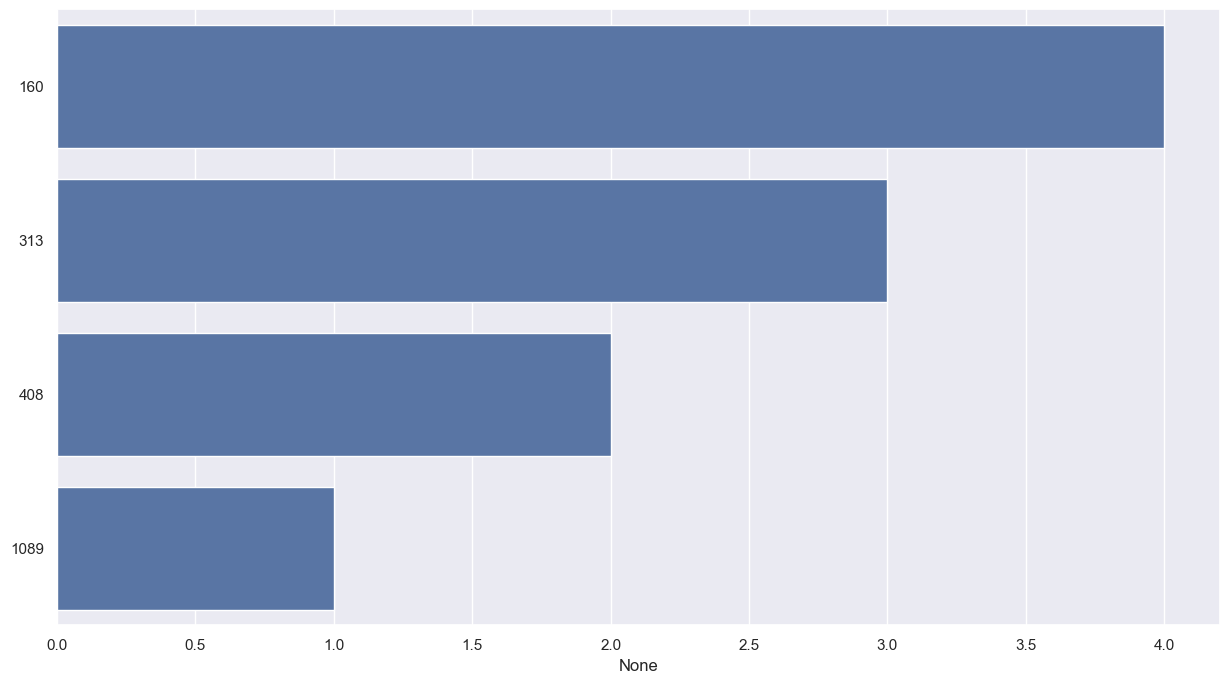

In [92]:
print(merged_dataset.corr()['KIQ400'].abs().sort_values(ascending=False))

value_counts = KIQ400.value_counts().sort_index()

sns.barplot(x=value_counts.index, y=value_counts.values, orient='h')

# plt.xticks([0, 1, 2, 3, 4])
# plt.xlabel('KIQ400 level')
# plt.ylabel('Count')
# plt.title('KIQ400 level Count')
# plt.show()

### Analysing the all features

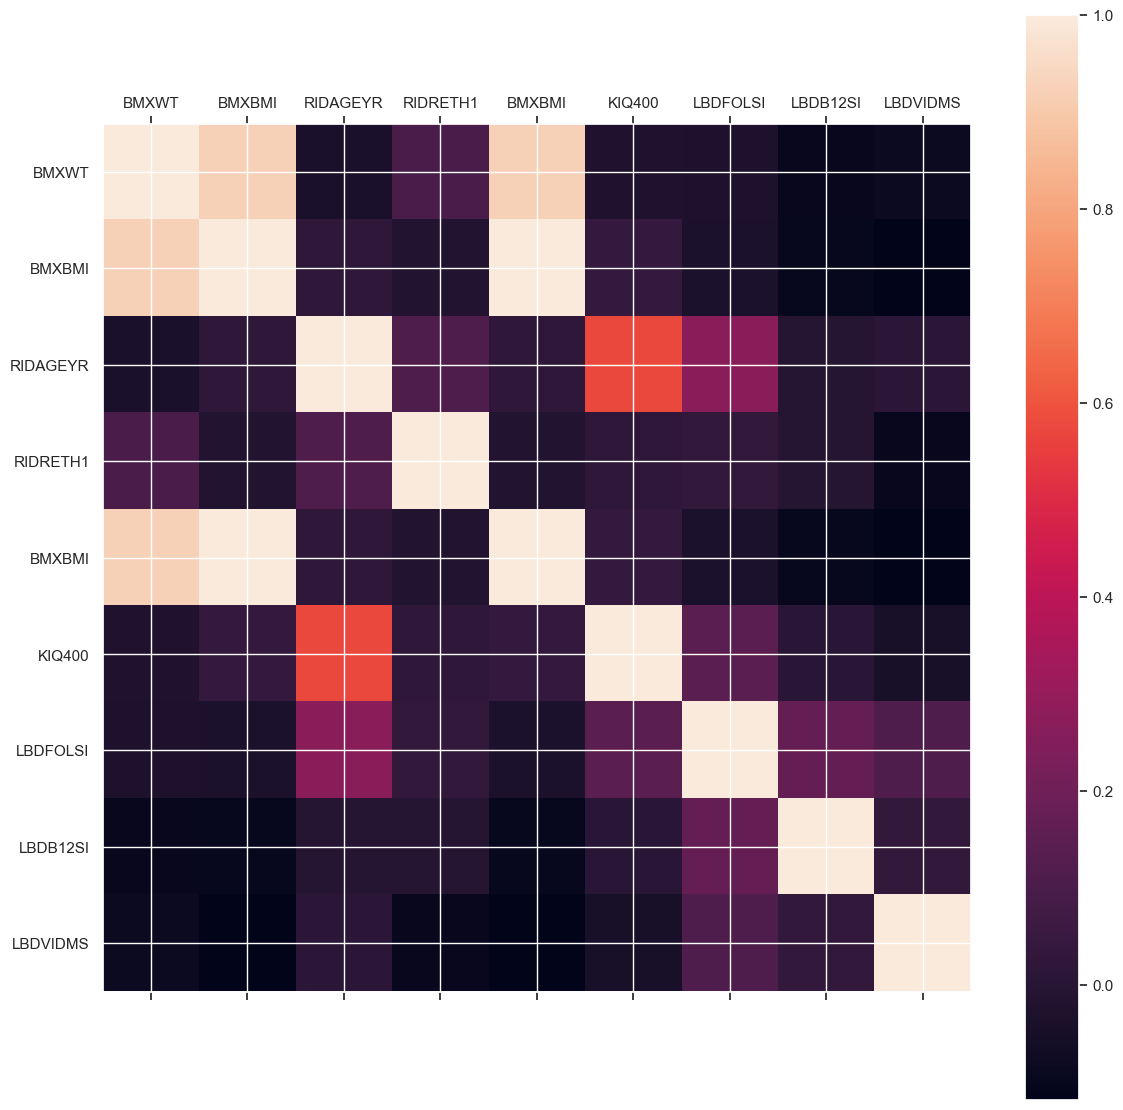

In [93]:
rcParams['figure.figsize'] = 20, 14
plt.matshow(merged_dataset.corr())
plt.yticks(np.arange(merged_dataset.shape[1]), merged_dataset.columns)
plt.xticks(np.arange(merged_dataset.shape[1]), merged_dataset.columns)
plt.colorbar()
plt.show()

## IV. Train Test split

In [94]:
predictors = merged_dataset.drop("KIQ400", axis=1)
# normalization
# for col in predictors.columns:
#     predictors[col] = (predictors[col] - predictors[col].min()) / (predictors[col].max() - predictors[col].min())

# print(predictors)
target = merged_dataset["KIQ400"]

X_train, X_test, Y_train, Y_test = train_test_split(predictors, target, test_size=0.20, random_state=32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1576, 8) (394, 8) (1576,) (394,)


## V. Model Fitting

### Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train,Y_train)

Y_pred_lr = lr.predict(X_test)

In [96]:
Y_pred_lr.shape

(394,)

In [97]:
score_lr = round(accuracy_score(Y_pred_lr,Y_test)*100,2)

print("The accuracy score achieved using Logistic Regression is: "+str(score_lr)+" %")

The accuracy score achieved using Logistic Regression is: 65.48 %


### Naive Bayes

In [98]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train,Y_train)

Y_pred_nb = nb.predict(X_test)

In [99]:
Y_pred_nb.shape

(394,)

In [100]:
score_nb = round(accuracy_score(Y_pred_nb,Y_test)*100,2)

print("The accuracy score achieved using Naive Bayes is: "+str(score_nb)+" %")

The accuracy score achieved using Naive Bayes is: 65.23 %


### SVM

In [101]:
from sklearn import svm

sv = svm.SVC(kernel='linear')

sv.fit(X_train, Y_train)

Y_pred_svm = sv.predict(X_test)

In [102]:
Y_pred_svm.shape

(394,)

In [103]:
score_svm = round(accuracy_score(Y_pred_svm,Y_test)*100,2)

print("The accuracy score achieved using Linear SVM is: "+str(score_svm)+" %")

The accuracy score achieved using Linear SVM is: 66.24 %


### K Nearest Neighbors

In [104]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,Y_train)
Y_pred_knn=knn.predict(X_test)

In [105]:
Y_pred_knn.shape

(394,)

In [106]:
score_knn = round(accuracy_score(Y_pred_knn,Y_test)*100,2)

print("The accuracy score achieved using KNN is: "+str(score_knn)+" %")

The accuracy score achieved using KNN is: 69.54 %


### Decision Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier

max_accuracy = 0


for x in range(1000):
    show_progress(1000,x+1)
    dt = DecisionTreeClassifier(random_state=x)
    dt.fit(X_train,Y_train)
    Y_pred_dt = dt.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_dt,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x

print('\n')
print('max accuracy:',max_accuracy)
print('best x:',best_x)


dt = DecisionTreeClassifier(random_state=best_x)
dt.fit(X_train,Y_train)
Y_pred_dt = dt.predict(X_test)

Progress:[▉▉▉▉▉▉▉▉▉▉] 100.0%

max accuracy: 74.62
best x: 0


In [108]:
print(Y_pred_dt.shape)

(394,)


In [109]:
score_dt = round(accuracy_score(Y_pred_dt,Y_test)*100,2)

print("The accuracy score achieved using Decision Tree is: "+str(score_dt)+" %")

The accuracy score achieved using Decision Tree is: 74.62 %


### Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier

max_accuracy = 0


for x in range(1000):
    show_progress(1000,x+1)
    rf = RandomForestClassifier(random_state=x,n_jobs=-1)
    rf.fit(X_train,Y_train)
    Y_pred_rf = rf.predict(X_test)
    current_accuracy = round(accuracy_score(Y_pred_rf,Y_test)*100,2)
    if(current_accuracy>max_accuracy):
        max_accuracy = current_accuracy
        best_x = x
        
print('\n')
print('max accuracy:',max_accuracy)
print('best x:',best_x)

rf = RandomForestClassifier(random_state=best_x)
rf.fit(X_train,Y_train)
Y_pred_rf = rf.predict(X_test)

Progress:[▉▉▉▉▉▉▉▉▉▉] 100.0%

max accuracy: 83.25
best x: 262


In [113]:
Y_pred_rf.shape

(394,)

In [114]:
score_rf = round(accuracy_score(Y_pred_rf,Y_test)*100,2)

print("The accuracy score achieved using Random Forest is: "+str(score_rf)+" %")

The accuracy score achieved using Random Forest is: 83.25 %


## VI. Output final score

In [126]:
scores = [score_lr,score_nb,score_svm,score_knn,score_dt,score_rf]
algorithms = ["Logistic Regression","Naive Bayes","SVM","KNN","Decision Tree","Random Forest"]    

for i in range(len(algorithms)):
    print("The accuracy score achieved using "+algorithms[i]+" is: "+str(scores[i])+" %")

The accuracy score achieved using Logistic Regression is: 65.48 %
The accuracy score achieved using Naive Bayes is: 65.23 %
The accuracy score achieved using SVM is: 66.24 %
The accuracy score achieved using KNN is: 69.54 %
The accuracy score achieved using Decision Tree is: 74.62 %
The accuracy score achieved using Random Forest is: 83.25 %


<Axes: xlabel='Algorithms', ylabel='Accuracy score'>

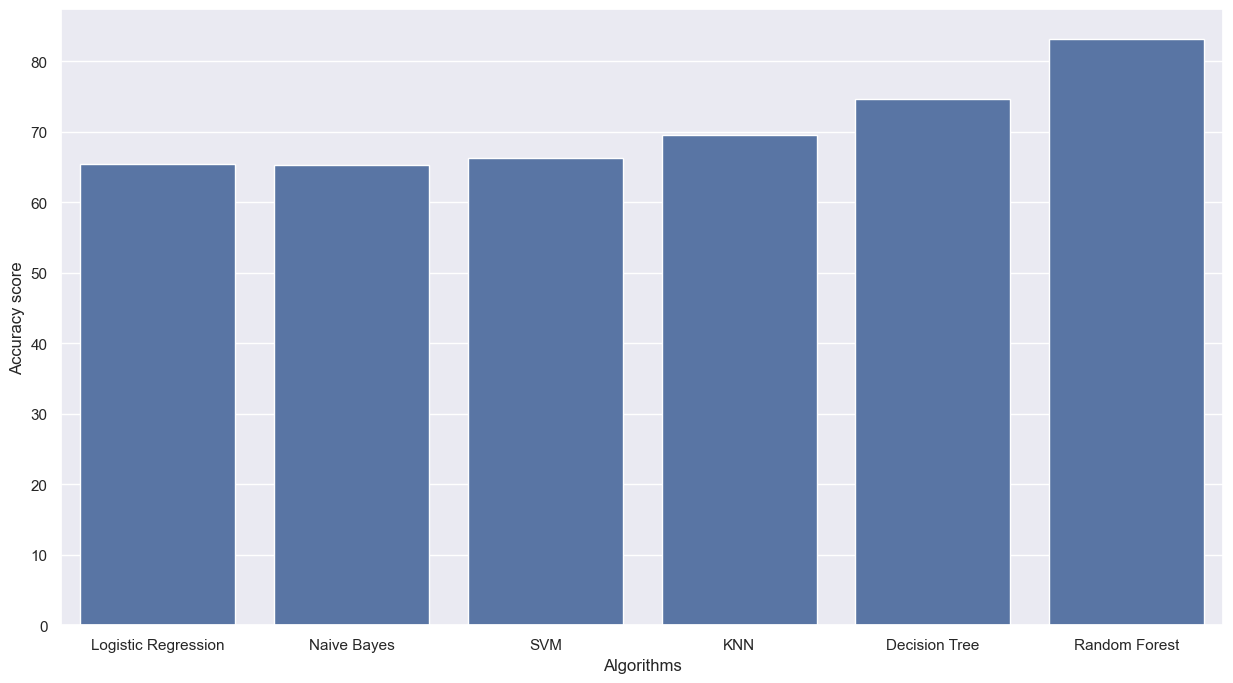

In [127]:
sns.set(rc={'figure.figsize':(15,8)})
plt.xlabel("Algorithms")
plt.ylabel("Accuracy score")

sns.barplot(x=algorithms,y=scores)